In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Implementing XGBoost model for **men**


# Libraries

In [1]:
# Base libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


In [2]:
# Auxiliary libraries for processing

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn import set_config

#!pip install scikit-learn==1.0.2
import pickle

In [3]:
# Installing packages
!pip install xgboost
!pip install shap

In [4]:
# Libraries for models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [5]:
# # Libraries for model evaluation and metrics
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    matthews_corrcoef,
    RocCurveDisplay,
    DetCurveDisplay
    )

In [6]:
# Libraries for explainability
from sklearn.inspection import permutation_importance
import shap

# Libraries for dimensionality reduction
from sklearn.decomposition import PCA

In [7]:
from xgboost import XGBClassifier

In [8]:
# Importing XGBoost properly
from xgboost import __version__ as xgboost_version
import shap

# Importing scikit-learn's version attribute directly
#from sklearn import __version__ as sklearn_version

# Function to display library versions
def show_versions():
    print("Versions of libraries used in the study:")
    print(f"Pandas: {pd.__version__}")
    print(f"NumPy: {np.__version__}")
    print(f"Matplotlib: {matplotlib.__version__}")
    print(f"Seaborn: {sns.__version__}")
   # print(f"Scikit-learn: {sklearn_version}")
    print(f"XGBoost: {xgboost_version}")
    print(f"SHAP: {shap.__version__}")

# Call the function to display library versions
show_versions()

Versions of libraries used in the study:
Pandas: 2.2.2
NumPy: 1.26.4
Matplotlib: 3.10.0
Seaborn: 0.13.2
XGBoost: 2.1.3
SHAP: 0.46.0


In [9]:
filename = "/content/drive/Othercomputers/Meu laptop/Doutorado/2023_1/Machine Learning/Database/data_for_python.txt"
df = pd.read_table(filename, delimiter='\t', index_col="subjID", na_values=["NA", "n/a", ""], keep_default_na=False)
df = df.loc[df['sex'] == 'Male']
df = df.drop('sex', axis=1)
df.head()

,age_group,marital_status,situation_household,family_support,friend_support,region,Poor_health,color,education,smoker,disease_diagnosis,diag_cancer,depression,mental_diseases_other,health_insurance,physical_exercise,BMI,obesity,drinking
subjID,,,,,,,,,,,,,,,,,,,
ID7,40-44,Married,Urbano,Three or more,Two,Norte,0,White,High,No,Yes,No,Yes,No,Yes,Yes,27.757487,No,Less than one by month
ID8,50-54,Married,Urbano,Three or more,Two,Norte,0,White,High,No,No,No,No,No,Yes,Yes,26.573129,No,Never
ID9,45-49,Single,Urbano,Two,Two,Norte,0,White,High,No,No,No,No,No,Yes,NaN,24.464602,No,Less than one by month
ID11,40-44,Single,Urbano,Three or more,Three or more,Norte,0,Pardo,Low,No,No,No,No,No,No,NaN,28.710479,No,Never
ID12,55-59,Single,Urbano,Two,Three or more,Norte,0,Pardo,Middle,Yes,No,No,No,No,No,NaN,21.952479,No,One or more by month


In [10]:
df.shape

(15163, 19)

In [11]:
df.columns

Index(['age_group', 'marital_status', 'situation_household', 'family_support',
       'friend_support', 'region', 'Poor_health', 'color', 'education',
       'smoker', 'disease_diagnosis', 'diag_cancer', 'depression',
       'mental_diseases_other', 'health_insurance', 'physical_exercise', 'BMI',
       'obesity', 'drinking'],
      dtype='object')

In [12]:
# Features

#Demographic
demog = ['age_group',  'marital_status', 'color', 'region', 'education', \
         'situation_household', 'family_support', 'friend_support']

# Clínical
clinical = ['smoker', 'disease_diagnosis', 'diag_cancer', 'depression', 'mental_diseases_other' \
       'health_insurance', 'physical_exercise', 'BMI', 'obesity', 'drinking']

In [14]:
# BFill method for missing values
df[["BMI", "obesity"]] = df[["BMI", "obesity"]].bfill(axis=0)
df = df.drop('physical_exercise', axis=1)

# Train and Test Set Split
In this project, I will use 25% of the data for testing. Additionally, since there is a class imbalance issue, I will perform stratified sampling to split the data.

In [16]:
X = df.drop(columns="Poor_health")
y = df["Poor_health"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22, stratify=y)

In [17]:
categorical_features = [ 'marital_status', 'situation_household', \
                        'region', 'color',  'smoker', 'disease_diagnosis', 'depression', \
       'diag_cancer', 'mental_diseases_other', 'health_insurance', 'obesity', 'drinking']
numeric_features = ['BMI']
multilabel_features = ['age_group','family_support', 'friend_support', 'education']

# transformer
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features+multilabel_features)
    ]
)

# XGBoost


In [18]:
# Changing the pipeline again with gridSearch

param_grid = {
    'clf__min_child_weight': [1, 5, 10],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__gamma': [0.5, 1, 1.5],
    'clf__n_estimators': [3,5,7,10,20],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__max_depth': [3, 4, 5]}

xgb_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", XGBClassifier(random_state=1, verbosity=0, n_jobs=-1, use_label_encoder=False))
    ]
)

grid_xgb_model = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error')

In [ ]:
#grid_xgb_model.fit(X_train, y_train)

In [ ]:
# Fitting the best estimator to the data

#xgb_male = grid_xgb_model.best_estimator_

In [19]:
#Saving the model

#with open("/content/drive/Othercomputers/Meu laptop/Doutorado/2023_1/Machine Learning/Database/ml_xgboost_male2.pkl", "wb") as fh:
    #pickle.dump(xgb_male, fh)

# Loading the model

with open("/content/drive/Othercomputers/Meu laptop/Doutorado/2023_1/Machine Learning/Database/ml_xgboost_male2.pkl", "rb") as fh:
    xgb_model = pickle.load(fh)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk.

## Featuring selection with XGBoost

In [20]:
#predictions
y_pred = xgb_model.predict(X_test)
y_pred.shape

(3791,)

In [21]:
# ROC curve
from sklearn.metrics import precision_recall_curve

probas_pred = xgb_model.predict_proba(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_true = y_test, probas_pred=probas_pred[:,-1])

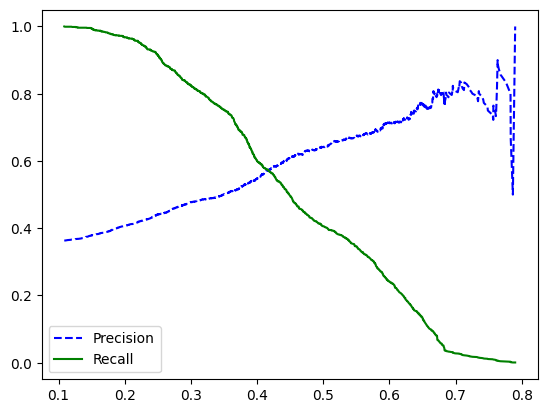

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Text(0.5, 1.0, 'Confusion Matrix')

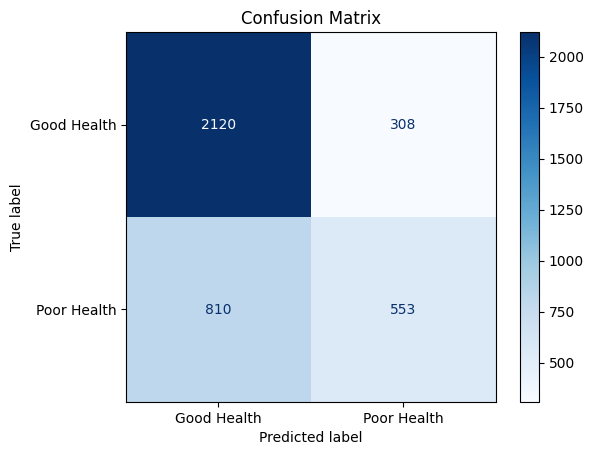

In [36]:
ConfusionMatrixDisplay.from_predictions(
    y_pred=y_pred,
    y_true=y_test,
    cmap=plt.cm.Blues,
    display_labels=["Good Health","Poor Health"])
plt.title("Confusion Matrix")


In [24]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    precision_recall_curve,
    confusion_matrix,
    roc_auc_score,
    roc_curve
    )

In [25]:
print(f'Accuracy = {accuracy_score(y_true=y_test, y_pred=y_pred):.2f}')
print(f'Precision = {precision_score(y_true=y_test, y_pred=y_pred):.2f}')
print(f'Recall = {recall_score(y_true=y_test, y_pred=y_pred):.2f}')
print(f'F1 score = {f1_score(y_true=y_test, y_pred=y_pred):.2f}')
roc_auc_score(y_test, probas_pred[:,-1])

Accuracy = 0.71
Precision = 0.64
Recall = 0.41
F1 score = 0.50


0.7385360147750444

# Feature Importance

In [27]:
list_numeric_names = list(xgb_model["preprocessor"].transformers_[0][1].get_feature_names_out(numeric_features))
list_cat_names = list(xgb_model["preprocessor"].transformers_[1][1].get_feature_names_out(categorical_features+multilabel_features))
features_names = list_numeric_names+list_cat_names

In [28]:
xgb_pred = xgb_model.predict_proba(X_test)
poor_health_prob = xgb_pred[:,1][y_test == 0]

In [29]:
df_proba = y_test.to_frame().copy()
df_proba["poor_srh_prob"] = list(xgb_pred[:,0])


df_proba = df_proba.merge(X_test, left_index=True, right_index=True)
df_proba.head()

,Poor_health,poor_srh_prob,age_group,marital_status,situation_household,family_support,friend_support,region,color,education,smoker,disease_diagnosis,diag_cancer,depression,mental_diseases_other,health_insurance,BMI,obesity,drinking
subjID,,,,,,,,,,,,,,,,,,,
ID6494,1,0.444973,45-49,Single,Rural,Three or more,Three or more,Nordeste,Pardo,Low,No,Yes,No,No,No,No,30.468750,Yes,One or more by month
ID28411,0,0.387889,45-49,Divorced,Urbano,Three or more,Three or more,Centro-Oeste,Black,Low,No,Yes,No,No,No,No,42.401983,Yes,Never
ID14038,0,0.691871,40-44,Married,Urbano,Three or more,Three or more,Nordeste,White,Low,No,No,No,No,No,No,32.871972,Yes,One or more by month
ID20639,0,0.817673,40-44,Married,Urbano,One,None,Sudeste,White,High,Yes,No,No,No,No,Yes,30.246914,Yes,One or more by month
ID5278,0,0.775308,45-49,Married,Urbano,Three or more,Two,Norte,Pardo,Middle,No,No,No,No,No,No,28.405504,No,One or more by month


In [30]:

list_numeric_names = list(xgb_model["preprocessor"].transformers_[0][1].get_feature_names_out(numeric_features))
list_cat_names = list(xgb_model["preprocessor"].transformers_[1][1].get_feature_names_out(categorical_features+multilabel_features))
features_names = list_numeric_names+list_cat_names

In [31]:
X_df = pd.DataFrame(preprocessor.fit_transform(X_test))
X_df.columns =features_names

#Dataframe X_test já preprocessado e com os nomes corretos.
X_df.head()

,BMI,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Widowed,situation_household_Rural,situation_household_Urbano,region_Centro-Oeste,region_Nordeste,region_Norte,...,family_support_One,family_support_Three or more,family_support_Two,friend_support_None,friend_support_One,friend_support_Three or more,friend_support_Two,education_High,education_Low,education_Middle
0,0.470090,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.844748,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.545542,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.463126,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.405312,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [32]:
explainer = shap.TreeExplainer(xgb_model["clf"])
shap_values = explainer.shap_values(X_df)

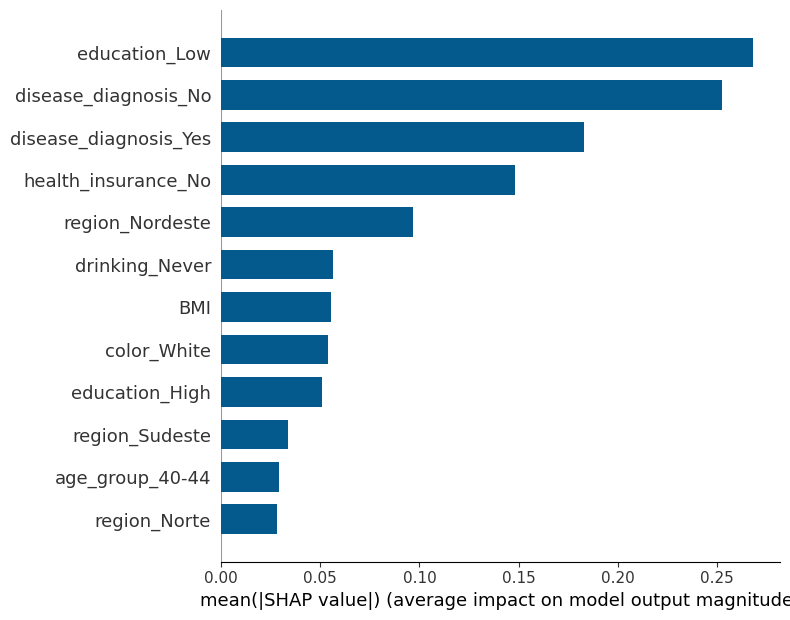

In [33]:
fig = plt.figure()
shap.summary_plot(shap_values, X_df, plot_type='bar', max_display=12, color = "#045a8d")

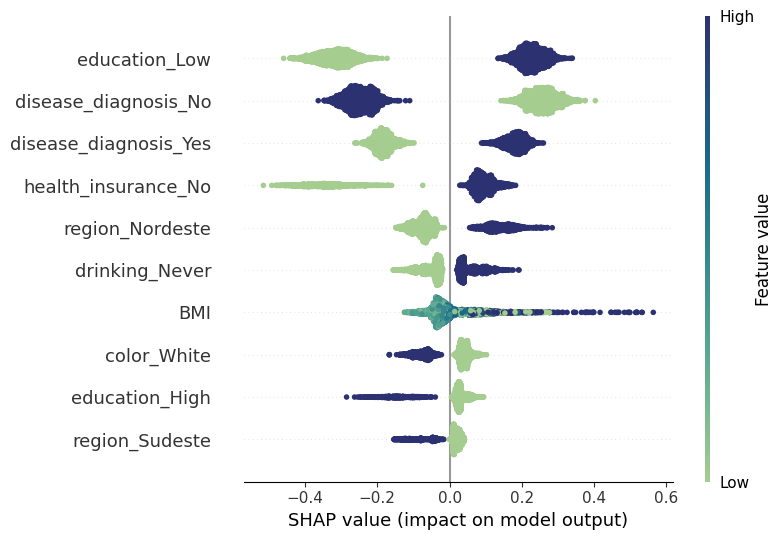

In [35]:
shap.summary_plot(shap_values, X_df,   max_display=10, cmap = "crest", show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(30)
plt.savefig('/content/drive/Othercomputers/Meu laptop/Doutorado/2023_1/Machine Learning/imgs/plot_shap_values_males.pdf')
plt.show()
